In [1]:
import model_api
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

# Train Networks on Midi Matrices

For the CNN, we will grab a fixed number of midi matrices per song (fill empty values with 0 matrices).
We'll use the stack of midi matrices as a three dimensional tensor input to be processed by convolutional layers.

The LSTM does not have the requirement of a fixed number of midi matrices, so we should be able to classify a song based on a variable number
of matrices.

I'll construct separate training sets based on the requirements of each model.

## CNN
The following code blocks construct the dataset for the convolutional neural network.

In [2]:
# Import Pretty MIDI data
fs2 = np.load("PreprocessedMidis/midisOP2_Fs2.npz")
song_keys = list(fs2.keys())
npz_labels = np.load("PreprocessedMidis/y_labels.npz")
label_keys = list(npz_labels.keys())

examples = []

longest_song = 0
for song in song_keys:
    song_array = fs2[song]
    song_length = song_array.shape[0]
    
    longest_song = max(song_length, longest_song)

print(f"Longest Song: {longest_song}")

Longest Song: 10338


#### Dataset Construction
Songs are variable in length and this is reflected in the feature extraction. The number of (36,3) matriceds per song is directly related to song-length. To reconcile the variable length input with the fixed dimensional inputs required my Convolutional Neural Network, our group decides to create several labels per song. We settled on creating as many (100, 36, 3) tensors as we could for each song, zero-padding the final tensor so that the information can still be used in training. For each of these tensors, we will attach the label of the original song. This process turns out training set of 1634 songs into 8752 tensors and labels.

In [3]:
def split_and_pad(array, target_shape=(100,36,3)):
    n, w, c = array.shape
    target_n, target_w, target_c = target_shape
    
    num_full_chunks = n // target_n
    chunks = [array[i*target_n:(i+1)*target_n] for i in range(num_full_chunks)]
    
    remainder = n % target_n
    if remainder > 0:
        remainder_array = array[num_full_chunks*target_n:]
        
        # Zero-pad the remainder array if it's smaller than the target size
        padding = ((0, target_n - remainder), (0, 0), (0, 0))
        padded_remainder = np.pad(remainder_array, padding, mode='constant', constant_values=0)
        chunks.append(padded_remainder)
    
    return chunks

In [4]:
examples = []
labels = []

for song, l_key in zip(song_keys, label_keys):
    song_array = fs2[song]
    label_value = npz_labels[l_key]

    chunks = split_and_pad(song_array)
    for chunk in chunks:
        examples.append(chunk)
        labels.append(label_value)

examples = np.array(examples)
labels = np.array(labels)

print("Examples Shape: ", examples.shape)
print("Labels Shape: ", labels.shape)

Examples Shape:  (8752, 100, 36, 3)
Labels Shape:  (8752, 4)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(examples, labels, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.1, random_state=1)

print(f"Training Set Size: {X_train.shape}")
print(f"Validation Set Size: {X_val.shape}")
print(f"Test Set Size: {X_test.shape}")

print(f"Training Label Size: {y_train.shape}")
print(f"Validation Label Size: {y_val.shape}")
print(f"Test Label Size: {y_test.shape}")

Training Set Size: (7001, 100, 36, 3)
Validation Set Size: (176, 100, 36, 3)
Test Set Size: (1575, 100, 36, 3)
Training Label Size: (7001, 4)
Validation Label Size: (176, 4)
Test Label Size: (1575, 4)


### CNN Training and Hyperparameter Tuning
Our convolutional neural network model only has two tunable hyperparameters.
These hyperparameters are dropout rate and hidden layer number. Our group decided to use a grid_search over the hyperparameters to find the model scoring the best on the validation set.

Once we have the model with the best validation accuracy, we will use this model on the test set and evaluate the performance of the convolutional neural network.

In [6]:
EPOCHS = 10
def train_cnn_model(dropout, hidden_layers, epochs=EPOCHS):
    cnn = model_api.opt2_cnn(100, 4, hidden_layers, dropout_rate=dropout)
    history = cnn.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32, verbose=0)
    
    val_accuracy = history.history["val_accuracy"][-1]
    val_loss = history.history["val_loss"][-1]
                               
    return cnn, val_accuracy, val_loss, history

Training Dropout: 0.1 Hidden Layer: 2
Training Dropout: 0.2 Hidden Layer: 2
Training Dropout: 0.30000000000000004 Hidden Layer: 2
Training Dropout: 0.4 Hidden Layer: 2
Training Dropout: 0.5 Hidden Layer: 2
Training Dropout: 0.1 Hidden Layer: 3
Training Dropout: 0.2 Hidden Layer: 3
Training Dropout: 0.30000000000000004 Hidden Layer: 3
Training Dropout: 0.4 Hidden Layer: 3
Training Dropout: 0.5 Hidden Layer: 3
Training Dropout: 0.1 Hidden Layer: 4
Training Dropout: 0.2 Hidden Layer: 4
Training Dropout: 0.30000000000000004 Hidden Layer: 4
Training Dropout: 0.4 Hidden Layer: 4
Training Dropout: 0.5 Hidden Layer: 4
Training Dropout: 0.1 Hidden Layer: 5
Training Dropout: 0.2 Hidden Layer: 5
Training Dropout: 0.30000000000000004 Hidden Layer: 5
Training Dropout: 0.4 Hidden Layer: 5
Training Dropout: 0.5 Hidden Layer: 5


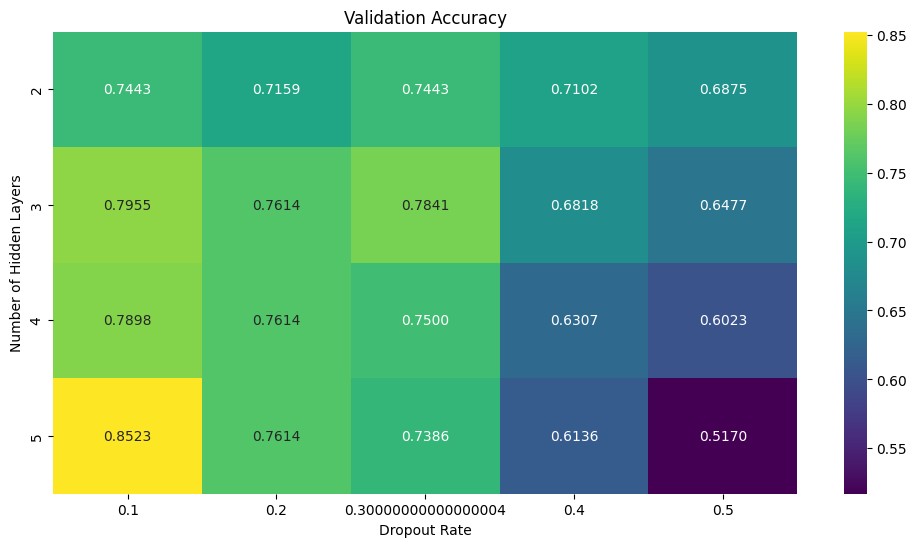

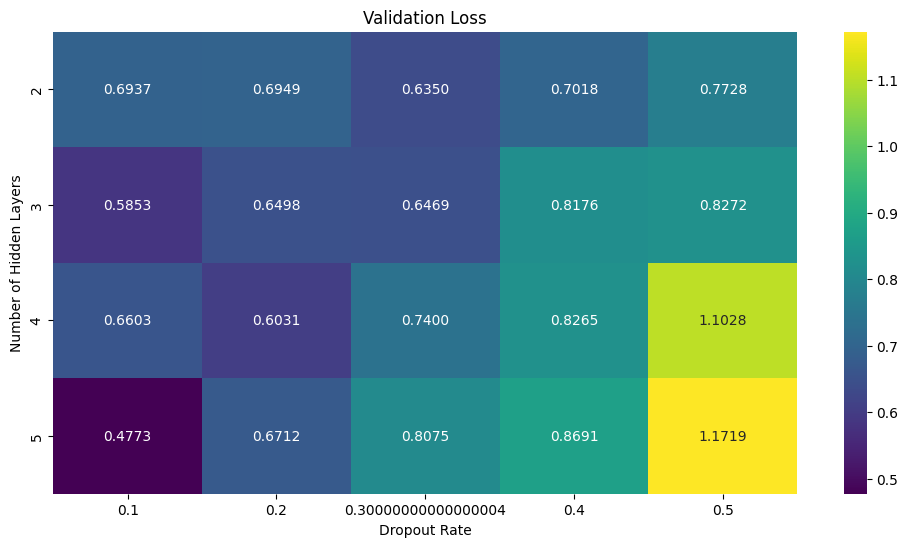

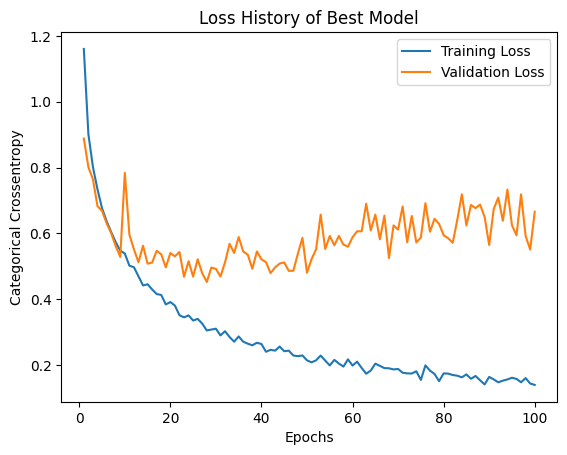

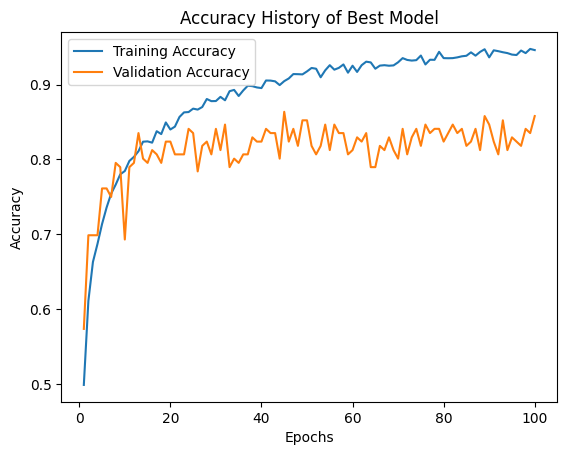

50/50 [==============================] - 0s 5ms/step - loss: 0.5487 - accuracy: 0.8489
Best Model Test Loss: 0.5487030148506165
Best Model Test Accuracy: 0.8488888740539551
50/50 [==============================] - 0s 3ms/step
Best Model Ancillary Results
Precision: 0.8492
Recall: 0.8489
F1-Score: 0.8475
50/50 [==============================] - 0s 3ms/step
Classification Report for Best Model:
              precision    recall  f1-score   support

     Class 1       0.94      0.96      0.95       626
     Class 2       0.83      0.77      0.80       446
     Class 3       0.72      0.59      0.65       118
     Class 4       0.76      0.85      0.80       385

    accuracy                           0.85      1575
   macro avg       0.81      0.79      0.80      1575
weighted avg       0.85      0.85      0.85      1575



In [8]:
# Grid Search Training Loop
dropout_values = np.linspace(0.1, 0.5, 5)
hidden_layer_values = [2, 3, 4, 5]

val_accuracies = np.zeros((len(hidden_layer_values), len(dropout_values)))
val_losses = np.zeros((len(hidden_layer_values), len(dropout_values)))

best_model = None
best_acc = -1
best_training_history = None
best_settings = None

for i, hidden_layers in enumerate(hidden_layer_values):
    for j, dropout_rate in enumerate(dropout_values):
        print(f"Training Dropout: {dropout_rate} Hidden Layer: {hidden_layers}")
        model, val_acc, val_loss, train_history = train_cnn_model(dropout_rate, hidden_layers)
        
        val_accuracies[i, j] = val_acc
        val_losses[i, j] = val_loss
        
        if val_acc > best_acc:
            best_model = model
            best_acc = val_acc
            best_training_history = train_history
            best_settings = (hidden_layers, dropout_rate)
            
# Heatmap for Validation Accuracy
plt.figure(figsize=(12, 6))
sns.heatmap(val_accuracies, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Validation Accuracy')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Heatmap for validation loss
plt.figure(figsize=(12, 6))
sns.heatmap(val_losses, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Validation Loss')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Retrain model on the best settings
EPOCHS = 100
hidden_layers, dropout_rate = best_settings
best_model, _, _, best_training_history = train_cnn_model(dropout_rate, hidden_layers, epochs=EPOCHS)

train_loss = best_training_history.history["loss"]
val_loss = best_training_history.history["val_loss"]

train_acc = best_training_history.history["accuracy"]
val_acc = best_training_history.history["val_accuracy"]

plt.plot(range(1,EPOCHS+1), train_loss, label="Training Loss")
plt.plot(range(1,EPOCHS+1), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy")
plt.legend()
plt.title("Loss History of Best Model")
plt.show()

plt.plot(range(1,EPOCHS+1), train_acc, label="Training Accuracy")
plt.plot(range(1,EPOCHS+1), val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy History of Best Model")
plt.show()

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Loss: {test_loss}")
print(f"Best Model Test Accuracy: {test_accuracy}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("Best Model Ancillary Results")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate and print classification report
report = classification_report(y_true, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
print("Classification Report for Best Model:")
print(report)

## LSTM Methodology

In [9]:
EPOCHS = 10
def train_lstm_model(dropout, hidden_layers, epochs=EPOCHS):
    lstm = model_api.opt2_lstm(4, hidden_layers, dropout_rate=dropout, max_len=100)
    history = lstm.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=1024, verbose=0)
    
    val_accuracy = history.history["val_accuracy"][-1]
    val_loss = history.history["val_loss"][-1]
                               
    return lstm, val_accuracy, val_loss, history

Training Dropout: 0.1 Hidden Layer: 2
Training Dropout: 0.2 Hidden Layer: 2
Training Dropout: 0.30000000000000004 Hidden Layer: 2
Training Dropout: 0.4 Hidden Layer: 2
Training Dropout: 0.5 Hidden Layer: 2
Training Dropout: 0.1 Hidden Layer: 3
Training Dropout: 0.2 Hidden Layer: 3
Training Dropout: 0.30000000000000004 Hidden Layer: 3
Training Dropout: 0.4 Hidden Layer: 3
Training Dropout: 0.5 Hidden Layer: 3
Training Dropout: 0.1 Hidden Layer: 4
Training Dropout: 0.2 Hidden Layer: 4
Training Dropout: 0.30000000000000004 Hidden Layer: 4
Training Dropout: 0.4 Hidden Layer: 4
Training Dropout: 0.5 Hidden Layer: 4
Training Dropout: 0.1 Hidden Layer: 5
Training Dropout: 0.2 Hidden Layer: 5
Training Dropout: 0.30000000000000004 Hidden Layer: 5
Training Dropout: 0.4 Hidden Layer: 5
Training Dropout: 0.5 Hidden Layer: 5


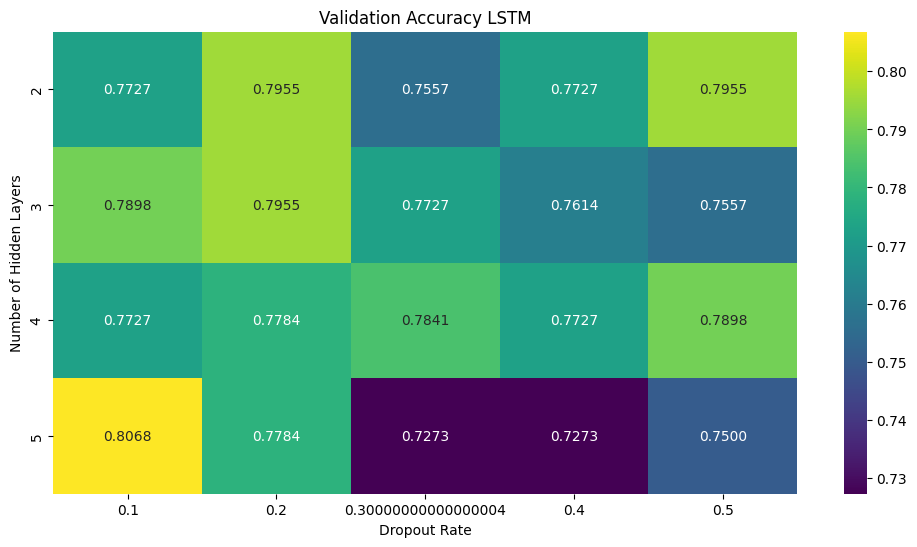

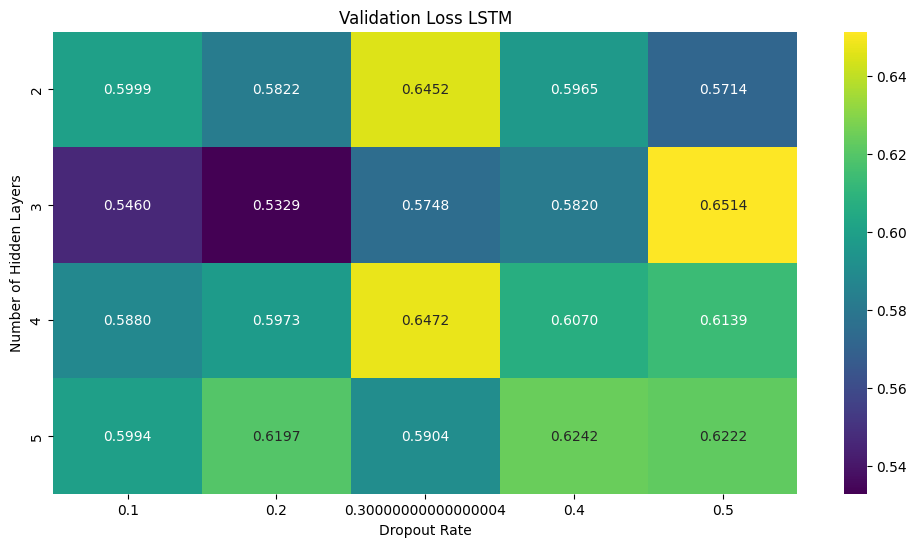

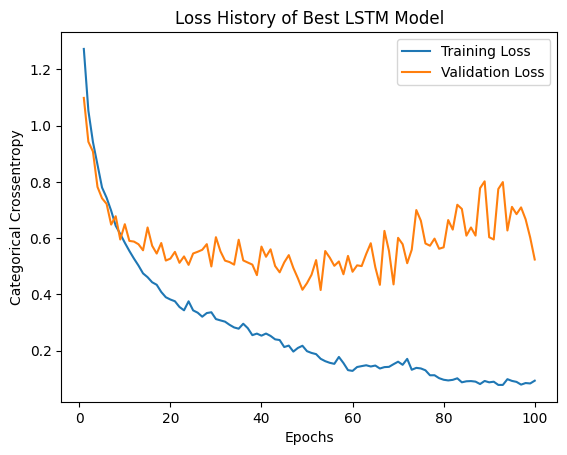

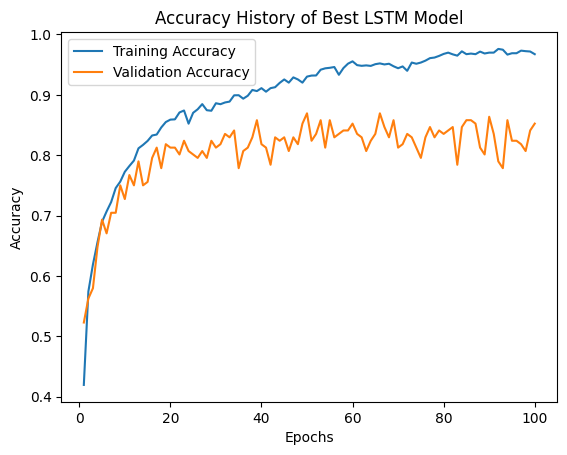

50/50 [==============================] - 2s 30ms/step - loss: 0.7491 - accuracy: 0.8197
Best LSTM Model Test Loss: 0.7491164207458496
Best LSTM Model Test Accuracy: 0.8196825385093689
50/50 [==============================] - 3s 29ms/step
Best LSTM Model Ancillary Results
Precision: 0.8218
Recall: 0.8197
F1-Score: 0.8198
50/50 [==============================] - 1s 28ms/step
Classification Report for Best LSTM Model:
              precision    recall  f1-score   support

     Class 1       0.93      0.92      0.93       626
     Class 2       0.80      0.74      0.77       446
     Class 3       0.65      0.61      0.63       118
     Class 4       0.72      0.81      0.76       385

    accuracy                           0.82      1575
   macro avg       0.78      0.77      0.77      1575
weighted avg       0.82      0.82      0.82      1575



In [10]:
# Grid Search Training Loop
dropout_values = np.linspace(0.1, 0.5, 5)
hidden_layer_values = [2, 3, 4, 5]

val_accuracies = np.zeros((len(hidden_layer_values), len(dropout_values)))
val_losses = np.zeros((len(hidden_layer_values), len(dropout_values)))

best_model = None
best_acc = -1
best_training_history = None
best_settings = None

for i, hidden_layers in enumerate(hidden_layer_values):
    for j, dropout_rate in enumerate(dropout_values):
        print(f"Training Dropout: {dropout_rate} Hidden Layer: {hidden_layers}")
        model, val_acc, val_loss, train_history = train_lstm_model(dropout_rate, hidden_layers, epochs=EPOCHS)
        
        val_accuracies[i, j] = val_acc
        val_losses[i, j] = val_loss
        
        if val_acc > best_acc:
            best_model = model
            best_acc = val_acc
            best_training_history = train_history
            best_settings = (hidden_layers, dropout_rate)

# Heatmap for Validation Accuracy
plt.figure(figsize=(12, 6))
sns.heatmap(val_accuracies, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Validation Accuracy LSTM')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Heatmap for validation loss
plt.figure(figsize=(12, 6))
sns.heatmap(val_losses, annot=True, fmt=".4f", xticklabels=dropout_values, yticklabels=hidden_layer_values, cmap='viridis')
plt.title('Validation Loss LSTM')
plt.xlabel('Dropout Rate')
plt.ylabel('Number of Hidden Layers')
plt.show()

# Retrain model on the best settings
EPOCHS = 100
hidden_layers, dropout_rate = best_settings
best_model, _, _, best_training_history = train_lstm_model(dropout_rate, hidden_layers, epochs=EPOCHS)

train_loss = best_training_history.history["loss"]
val_loss = best_training_history.history["val_loss"]

train_acc = best_training_history.history["accuracy"]
val_acc = best_training_history.history["val_accuracy"]

plt.plot(range(1,EPOCHS+1), train_loss, label="Training Loss")
plt.plot(range(1,EPOCHS+1), val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Categorical Crossentropy")
plt.legend()
plt.title("Loss History of Best LSTM Model")
plt.show()

plt.plot(range(1,EPOCHS+1), train_acc, label="Training Accuracy")
plt.plot(range(1,EPOCHS+1), val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy History of Best LSTM Model")
plt.show()

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Best LSTM Model Test Loss: {test_loss}")
print(f"Best LSTM Model Test Accuracy: {test_accuracy}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print("Best LSTM Model Ancillary Results")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate and print classification report
report = classification_report(y_true, y_pred_classes, target_names=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
print("Classification Report for Best LSTM Model:")
print(report)

# Train Neural Networks on audio files.

In [17]:
# Import Pretty MIDI data
audio_data = np.load("AudioData/train_dataset.npz")

examples = audio_data['features']
labels = audio_data['labels']

print(examples.shape)
print(labels.shape)

(284, 2)
(284,)
